<a href="https://colab.research.google.com/github/berggama/bootcamp_unimed/blob/main/machine_learning_para_prever_evolu%C3%A7%C3%A3o_do_COVID_19_no_brasil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão da Evolução do COVID-19 no Brasil
## Modelo Preditivo

### Descrição

Nesse notebook investiguei os dados da disseminação do COVID-19 no Brasil desde o início da pandemia em fevereiro de 2020. Apresento os padrões de disseminação da doença, analiso os números de infectados, de recuperados e de óbitos, para construir modelos com Python e Machine Learning para prever os números nos dias seguintes e o ponto de virada da curva de infecção baseado em alguns cenários.

O dataset escolhido para análise é o Novel Corona Virus 2019 Dataset do Kaggle, que foi construído com informações geográficas do Google sobre o COVID-19, se caracterizando como uma série temporal. 

Para previsões mais parrudas, seria necessários mais dados. Esse se trata de um modelo mais simples para, posteriormente, chegar a modelos mais complexos.

# 1) Imports

In [308]:
#importando bibliotecas
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from IPython.core.display  import HTML
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from fbprophet import Prophet
from prophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

# 2) Funções auxiliares

In [151]:
# Função para melhorar a visualização de gráficos

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [10,6]
    plt.rcParams['font.size'] = 15
    
    display( HTML('<style.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
jupyter_settings()


# Função para calcular a média da Taxa de crescimento 
def taxa_crescimento(data, feature, start_date=None, end_date=None):
  #Caso a data de início não seja definida, pegar a menor data disponível:
  if start_date == None:
    start_date = data.observationdate.loc[data[feature]>0].min()
  else:
    start_date = pd.to_datetime(start_date)

  #Caso a data final não seja definida
  if end_date == None:
    end_date = data.observationdate.iloc[-1]
  else:
    end_date = pd.to_datetime(end_date)

  #definindo os valores de passado e presente
  past = data.loc[data.observationdate == start_date, feature].values[0]
  present = data.loc[data.observationdate == end_date, feature].values[0]

  #definindo o número de confirmados ao longo do tempo
  n = (end_date - start_date).days
  
  #calcular a taxa
  taxa = ((present/past)**(1/n))-1
  
  return taxa*100

# Função para calcular a Taxa de crescimento diária
def taxa_crescimento_diario(data, feature, start_date=None):
   # Caso a data de início não seja definida, pegar a menor data disponível
   if start_date == None:
     start_date = data.observationdate.loc[data[feature]>0].min()
   else:
     start_date = pd.to_datetime(start_date)
    
  # Definindo a data final:
   end_date = data.observationdate.max()

  # Período calculado
   n = (end_date - start_date).days

  # Taxa calculada de um dia para o outro
   taxas = list(map(lambda x: (data[feature].iloc[x]-data[feature].iloc[x-1]) / data[feature].iloc[x-1], range(1,n+1)))
  
   return np.array(taxas)*100

Populating the interactive namespace from numpy and matplotlib


# 3) Carregando dados

In [152]:
df_raw = pd.read_csv('/content/drive/MyDrive/Data Science/DIO/Python para Ciência de Dados/Desafios de Projetos/dataset/covid_19_data.csv')

In [153]:
# observando o dataset
df_raw.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


Descrição das colunas:

- Sno - Serial number;
- ObservationDate - Data do registro no formato MM/DD/YYYY;
- Province/State - Província ou estado do registro;
- Country/Region - País do registro;
- Last Update - Última atualização, tempo em UTC, no fuso do país de registro;
- Confirmed - Montante de casos confirmados até a data;
- Deaths - Montante de mortes até a data;
- Recovered - Montante de recuperados até a data;

# 4) Descrição dos dados

In [155]:
#criando cópia do dataframe inicial
df1 = df_raw.copy()

## 4.1) Renomeando colunas

In [156]:
#renomear colunas para facilitar o trabalho futuro (tirar espaços e manter lowercase)
df1.columns

Index(['SNo', 'ObservationDate', 'Province/State', 'Country/Region',
       'Last Update', 'Confirmed', 'Deaths', 'Recovered'],
      dtype='object')

In [157]:
old_cols = ['SNo', 'ObservationDate', 'Province/State', 'Country/Region',
       'Last Update', 'Confirmed', 'Deaths', 'Recovered']

df1.columns = df1.columns.str.replace(" ", "_", regex=True).str.lower()

In [158]:
df1.columns

Index(['sno', 'observationdate', 'province/state', 'country/region',
       'last_update', 'confirmed', 'deaths', 'recovered'],
      dtype='object')

## 4.2) Separar o dataset com os dados do Brasil

In [159]:
# Filtrando Brazil no campo country/region
df1 = df1[df1['country/region']=='Brazil']
df1.head()

,sno,observationdate,province/state,country/region,last_update,confirmed,deaths,recovered
84,85,01/23/2020,NaN,Brazil,1/23/20 17:00,0.0,0.0,0.0
2525,2526,02/26/2020,NaN,Brazil,2020-02-26T23:53:02,1.0,0.0,0.0
2631,2632,02/27/2020,NaN,Brazil,2020-02-26T23:53:02,1.0,0.0,0.0
2742,2743,02/28/2020,NaN,Brazil,2020-02-26T23:53:02,1.0,0.0,0.0
2852,2853,02/29/2020,NaN,Brazil,2020-02-29T21:03:05,2.0,0.0,0.0


In [160]:
# Filtrando as observações onde os casos confirmados são iguais a zero (ou seja, vamos trabalhar apenas com as observações
# referentes ao momento após a chegada do COVID no Brasil)
df1 = df1[df1['confirmed']>0]
df1.head()

,sno,observationdate,province/state,country/region,last_update,confirmed,deaths,recovered
2525,2526,02/26/2020,NaN,Brazil,2020-02-26T23:53:02,1.0,0.0,0.0
2631,2632,02/27/2020,NaN,Brazil,2020-02-26T23:53:02,1.0,0.0,0.0
2742,2743,02/28/2020,NaN,Brazil,2020-02-26T23:53:02,1.0,0.0,0.0
2852,2853,02/29/2020,NaN,Brazil,2020-02-29T21:03:05,2.0,0.0,0.0
2981,2982,03/01/2020,NaN,Brazil,2020-02-29T21:03:05,2.0,0.0,0.0


## 4.3) Dimensão dos dados

In [161]:
#verificando o tamanho do dataframe
print( 'Número de linhas: {}' .format (df1.shape[0]) )
print( 'Número de colunas: {}' .format (df1.shape[1]) )

Número de linhas: 10209
Número de colunas: 8


## 4.4) Tipo dos dados

In [162]:
#verificando os tipos dos dados
df1.dtypes

sno                  int64
observationdate     object
province/state      object
country/region      object
last_update         object
confirmed          float64
deaths             float64
recovered          float64
dtype: object

In [163]:
# Trocando tipo de dados, visto que 'sno' pode ser interpretado como string e 'observationdate' e 'last_update' são datas
df1[['sno']] = df1[['sno']].astype('object')
df1['observationdate'] = pd.to_datetime(df1['observationdate'])
df1['last_update'] = pd.to_datetime(df1['last_update'])
df1.dtypes

sno                        object
observationdate    datetime64[ns]
province/state             object
country/region             object
last_update        datetime64[ns]
confirmed                 float64
deaths                    float64
recovered                 float64
dtype: object

## 4.5) Check NA

In [164]:
#verificando a existência de NA's nas colunas 
df1.isna().sum()

sno                 0
observationdate     0
province/state     84
country/region      0
last_update         0
confirmed           0
deaths              0
recovered           0
dtype: int64

In [165]:
df1.columns

Index(['sno', 'observationdate', 'province/state', 'country/region',
       'last_update', 'confirmed', 'deaths', 'recovered'],
      dtype='object')

In [166]:
# Ao analisar o dataset, é possível ver que inicialmente, nos primeiros 84 dias, não foi especificado o estado brasileiro de registro, 
# sendo contabilizado, por tanto, o total de casos no Brasil, sem distinção de estados. Sendo assim, irei ignorar a coluna estados e agruparei todos as
# informações a nível País (foi necessário terir a coluna sno, já que ela fazia todo registro ter uma identificação diferente)
df1 = df1[['observationdate', 'country/region',
       'last_update', 'confirmed', 'deaths', 'recovered']].groupby(['observationdate', 'country/region','last_update']).sum().reset_index()
df1.head(90)

,observationdate,country/region,last_update,confirmed,deaths,recovered
0,2020-02-26,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
1,2020-02-27,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2,2020-02-28,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
3,2020-02-29,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0
4,2020-03-01,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0
5,2020-03-02,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0
6,2020-03-03,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0
7,2020-03-04,Brazil,2020-03-04 20:33:02,4.0,0.0,0.0
8,2020-03-05,Brazil,2020-03-04 20:33:02,4.0,0.0,0.0
9,2020-03-06,Brazil,2020-03-06 20:33:03,13.0,0.0,0.0


# 5) Feature Engineering

In [167]:
# backup
df2 = df1.copy()

In [168]:
# Derivar algumas variáveis de tempo

#ano
df2['ano'] = df2['observationdate'].dt.year

#mes
df2['mes'] = df2['observationdate'].dt.month

#dia
df2['dia'] = df2['observationdate'].dt.day

#dia da semana
df2['dia_semana'] = df2['observationdate'].dt.weekday
df2['dia_semana'] = df2['dia_semana'].apply(lambda x: 'segunda' if x==0 else 'terca' if x== 1 else 'quarta' if x== 2 else 'quinta' if x== 3 else 'sexta' if x== 4 else 'sabado' if x== 5 else 'domingo')

#semana do ano
df2['ano_semana'] = df2['observationdate'].dt.strftime('%Y-%W')

In [169]:
# Alterando o tipo das novas variáveis
df2[['ano', 'mes', 'dia']] = df2[['ano', 'mes', 'dia']].astype('object')

In [170]:
df2.head()

,observationdate,country/region,last_update,confirmed,deaths,recovered,ano,mes,dia,dia_semana,ano_semana
0,2020-02-26,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,2020,2,26,quarta,2020-08
1,2020-02-27,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,2020,2,27,quinta,2020-08
2,2020-02-28,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,2020,2,28,sexta,2020-08
3,2020-02-29,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0,2020,2,29,sabado,2020-08
4,2020-03-01,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0,2020,3,1,domingo,2020-08


# 6) Estatística Descritiva

In [171]:
#Separando as colunas em atributos numéricos e categóricos
num_attributes = df2.select_dtypes( include=['int64', 'float64', 'int32'] )
cat_attributes = df2.select_dtypes( exclude=['int64', 'float64', 'int32' , 'datetime64[ns]'] )

In [172]:
df2.dtypes

observationdate    datetime64[ns]
country/region             object
last_update        datetime64[ns]
confirmed                 float64
deaths                    float64
recovered                 float64
ano                        object
mes                        object
dia                        object
dia_semana                 object
ano_semana                 object
dtype: object

## 6.1) Atributos Numéricos

In [173]:
# Verificando as estatísticas dos atributos numéricos
num_attributes.agg(["mean","median","std","min","max","skew","kurtosis"]).T.reset_index().rename(columns={'index': 'attributes'})

,attributes,mean,median,std,min,max,skew,kurtosis
0,confirmed,5.781236e+06,5103408.0,4.912113e+06,1.0,16471600.0,0.529060,-0.852252
1,deaths,1.582236e+05,150689.0,1.257373e+05,0.0,461057.0,0.627036,-0.367309
2,recovered,5.032672e+06,4526393.0,4.414654e+06,0.0,14496224.0,0.507158,-0.909916


## 6.2) Atributos categóricos

In [174]:
#verificando quantas categorias cada atributo possui 
cat_attributes.apply(lambda x: x.unique().shape[0])

country/region     1
ano                2
mes               12
dia               31
dia_semana         7
ano_semana        67
dtype: int64

## 7) Hipóteses para análise

Não temos muitos dados no dataset, seja de variáveis, seja de observações, portanto para esse caso, construir hipóteses para aprofundar a análise não fará sentido;

## 8) Análise Exploratória de Dados

In [175]:
df3 = df2.copy()

## 8.1) Análise Univariada

Entender o comportamente de cada variável de forma independente;

### 8.1.1) Variável resposta

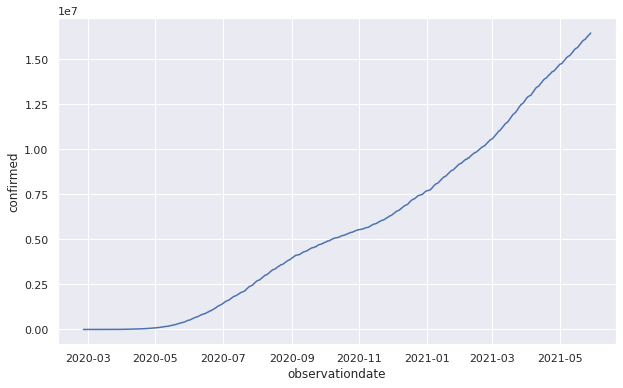

In [176]:
# Construindo uma série temporal para entender o comportamento da variável resposta (confirmed):
sns.lineplot(data=df3, x=df3['observationdate'], y=df3['confirmed'])
# Vemos uma crescente nos casos confirmados, justamente por representar um montante, mas conseguimos reparar que quanto maior a inclinação, maior o aumento 
# nos casos confirmados (maior crescimento no eixo y, num curto período de tempo)

#### 8.1.1.1) Tirando insights da variável resposta

In [177]:
# Calculando o número de casos confirmados por dia
df3['new_cases'] = list(map(lambda x: 0 if (x==0) else df3['confirmed'].iloc[x]-df3['confirmed'].iloc[x-1], np.arange(df3.shape[0])))
df3.head()

,observationdate,country/region,last_update,confirmed,deaths,recovered,ano,mes,dia,dia_semana,ano_semana,new_cases
0,2020-02-26,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,2020,2,26,quarta,2020-08,0.0
1,2020-02-27,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,2020,2,27,quinta,2020-08,0.0
2,2020-02-28,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,2020,2,28,sexta,2020-08,0.0
3,2020-02-29,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0,2020,2,29,sabado,2020-08,1.0
4,2020-03-01,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0,2020,3,1,domingo,2020-08,0.0


In [178]:
# calculando a taxa de crescimento médio dos confirmados 
print(round(taxa_crescimento(df3, 'confirmed'),2))

3.69


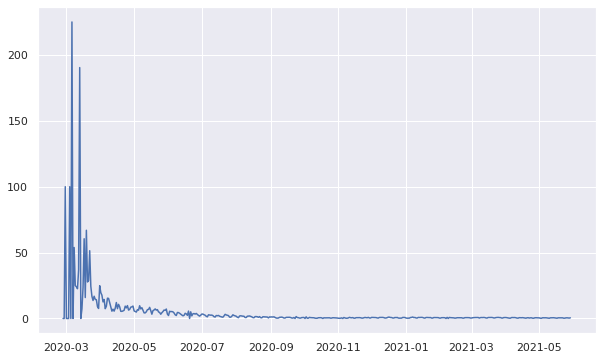

In [179]:
# calculando a taxa diária de crescimento dos casos confirmados e plotando em gráfico
primeiro_dia = df3['observationdate'].loc[df3['confirmed']>0].min()
sns.lineplot(x=pd.date_range(primeiro_dia, df3['observationdate'].max())[1:], y=taxa_crescimento_diario(df3,'confirmed'))

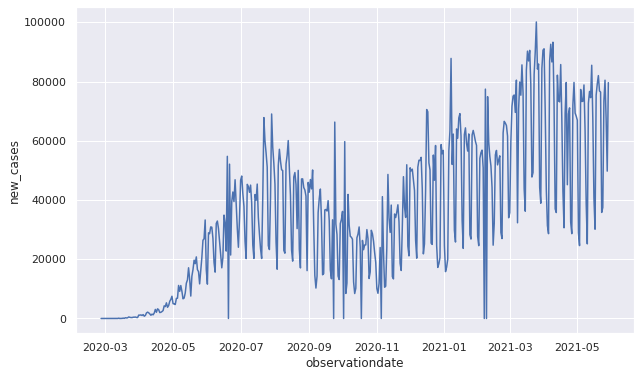

In [180]:
# Construindo uma série temporal
sns.lineplot(data=df3, x=df3['observationdate'], y=df3['new_cases'])
# É visto um aumento gradual dos casos diários e a movimentação em ondas;

### 8.1.2) Demais variáveis

#### 8.1.2.1) Deaths

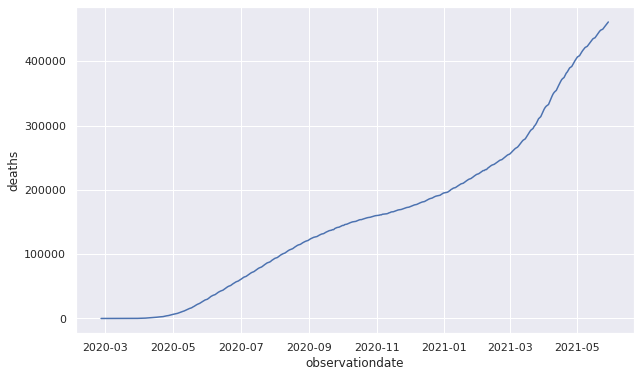

In [181]:
# plotando seu comportamento em relação ao tempo
sns.lineplot(data=df3, x=df3['observationdate'], y=df3['deaths'])
# comportamento bastante semelhante ao de casos confirmados (obviamente há uma relação de causa e efeito)

In [182]:
# calculando a taxa de crescimento médio das mortes
print(round(taxa_crescimento(df3, 'deaths'),2))

3.02


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning:

divide by zero encountered in double_scalars



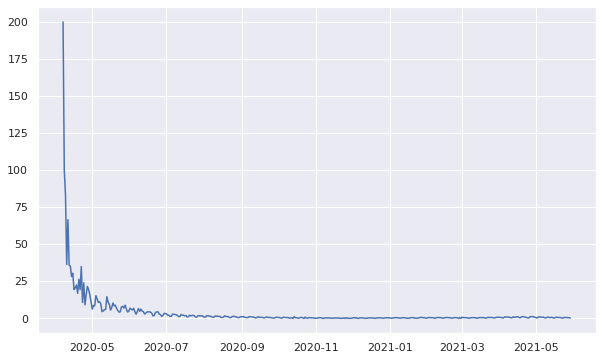

In [183]:
# calculando a taxa diária de crescimento das mortes e plotando em gráfico
primeiro_dia = df3['observationdate'].loc[df3['deaths']>0].min()
sns.lineplot(x=pd.date_range(primeiro_dia, df3['observationdate'].max())[1:], y=taxa_crescimento_diario(df3,'deaths'))

In [184]:
# Explorado os dados
df3['new_deaths'] = list(map(lambda x: 0 if (x==0) else df3['deaths'].iloc[x]-df3['deaths'].iloc[x-1], np.arange(df3.shape[0])))
df3.head()

,observationdate,country/region,last_update,confirmed,deaths,recovered,ano,mes,dia,dia_semana,ano_semana,new_cases,new_deaths
0,2020-02-26,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,2020,2,26,quarta,2020-08,0.0,0.0
1,2020-02-27,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,2020,2,27,quinta,2020-08,0.0,0.0
2,2020-02-28,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,2020,2,28,sexta,2020-08,0.0,0.0
3,2020-02-29,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0,2020,2,29,sabado,2020-08,1.0,0.0
4,2020-03-01,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0,2020,3,1,domingo,2020-08,0.0,0.0


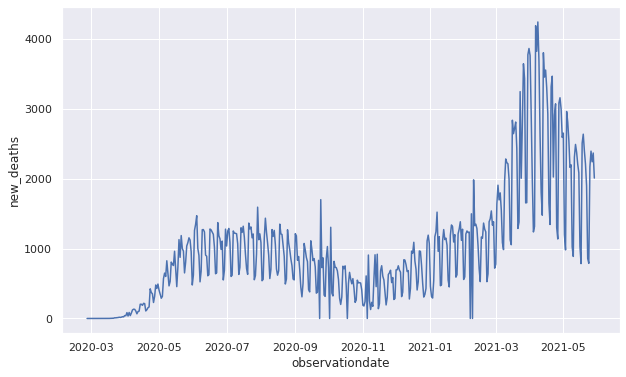

In [185]:
# Construindo uma série temporal
sns.lineplot(data=df3, x=df3['observationdate'], y=df3['new_deaths']);
# É possível visualizar a segunda onda, tendo muitas mortes diárias

#### 8.1.2.2) Recovered

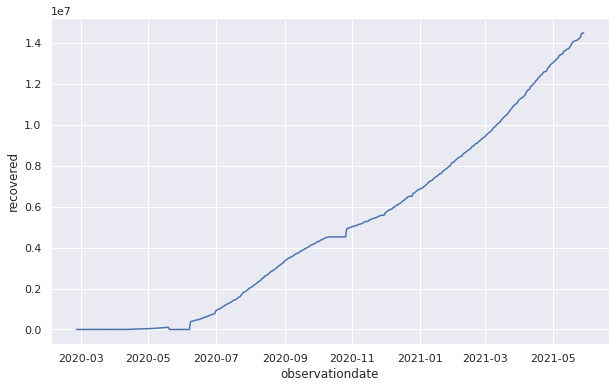

In [186]:
# plotando seu comportamento em relação ao tempo
sns.lineplot(data=df3, x=df3['observationdate'], y=df3['recovered'])
# curva diferente das demais, mas também segue um crescimento positivo, com uma aparente taxa de crescimento maior do que as demais;

In [187]:
# calculando a taxa de crescimento média de recuperados no período
print(round(taxa_crescimento(df3, 'recovered'),2))

3.83


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning:

divide by zero encountered in double_scalars



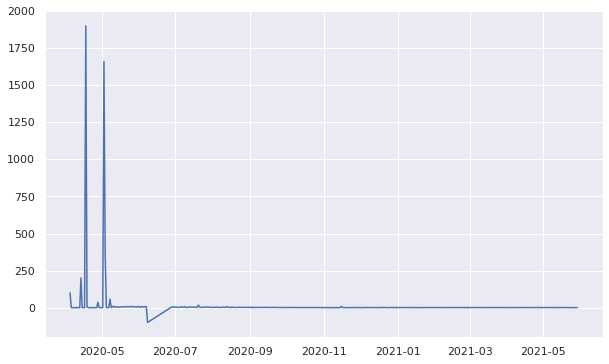

In [188]:
# calculando a taxa diária de crescimento dos recuperados e plotando em gráfico
primeiro_dia = df3['observationdate'].loc[df3['recovered']>0].min()
sns.lineplot(x=pd.date_range(primeiro_dia, df3['observationdate'].max())[1:], y=taxa_crescimento_diario(df3,'recovered'))

In [189]:
# Explorado os dados
df3['new_recovered'] = list(map(lambda x: 0 if (x==0) else df3['recovered'].iloc[x]-df3['recovered'].iloc[x-1], np.arange(df3.shape[0])))
df3.head()

,observationdate,country/region,last_update,confirmed,deaths,recovered,ano,mes,dia,dia_semana,ano_semana,new_cases,new_deaths,new_recovered
0,2020-02-26,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,2020,2,26,quarta,2020-08,0.0,0.0,0.0
1,2020-02-27,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,2020,2,27,quinta,2020-08,0.0,0.0,0.0
2,2020-02-28,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,2020,2,28,sexta,2020-08,0.0,0.0,0.0
3,2020-02-29,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0,2020,2,29,sabado,2020-08,1.0,0.0,0.0
4,2020-03-01,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0,2020,3,1,domingo,2020-08,0.0,0.0,0.0


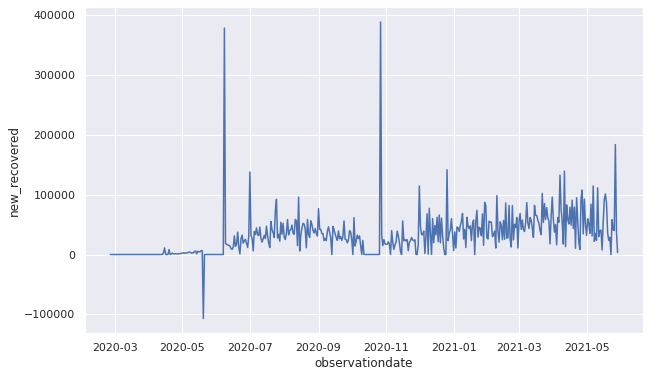

In [190]:
# Construindo uma série temporal
sns.lineplot(data=df3, x=df3['observationdate'], y=df3['new_recovered'])

# 9) Machine Learning

In [191]:
df4 = df3.copy()

## 9.1) Predição de casos confirmados

In [192]:
# Separando o dataset
confirmados = df4['confirmed']
confirmados.index = df4['observationdate']
confirmados.head()

observationdate
2020-02-26    1.0
2020-02-27    1.0
2020-02-28    1.0
2020-02-29    2.0
2020-03-01    2.0
Name: confirmed, dtype: float64

In [193]:
# decompondo o dataset para entender os dados observados, sua tendência, a sazonalidade e o resíduo dos dados
res = (seasonal_decompose(confirmados))

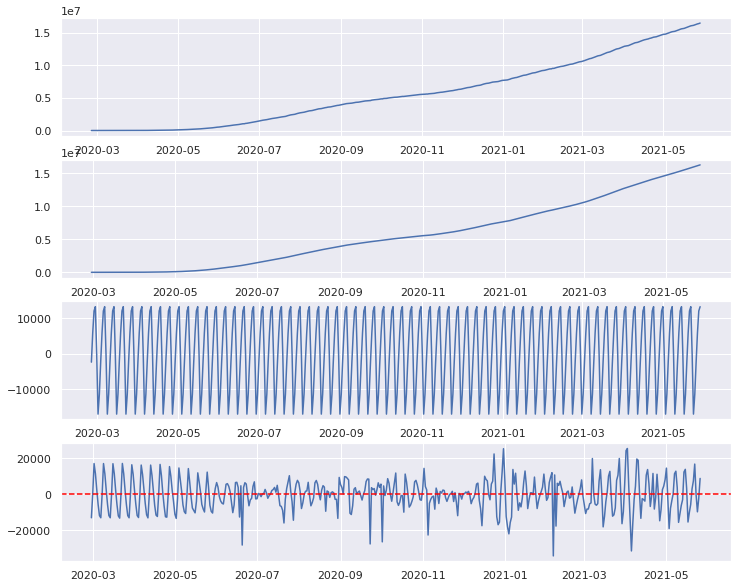

In [194]:
# Plotando o gráfico com os resultados
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (12,10))

ax1.plot(res.observed)
ax2.plot(res.trend)
ax3.plot(res.seasonal)
ax4.plot(confirmados.index, res.resid)
ax4.axhline(0, linestyle='dashed', c='red')
plt.show()

### 9.1.1) Modelando dados com ARIMA

In [198]:
modelo = auto_arima(confirmados)
fig = go.Figure(go.Scatter(x=confirmados.index, y=confirmados, name='Observados'))

fig.add_trace(go.Scatter(x=confirmados.index, y=modelo.predict_in_sample(), name='Preditos'))

fig.add_trace(go.Scatter(x=pd.date_range('2021-05-29', '2021-06-29'), y=modelo.predict(31), name='Previsão'))

fig.show()

### 9.1.2) Modelando dados com fbprophet

In [317]:
# Separando dataset em Treino e Teste
train = confirmados.reset_index()[:-50]
test = confirmados.reset_index()[-50:]

# Renomeando colunas
train.rename(columns={'observationdate':'ds', 'confirmed':'y'}, inplace=True)
test.rename(columns={'observationdate':'ds', 'confirmed':'y'}, inplace=True)

# Definir o modelo de crescimento 
my_model = Prophet(interval_width=0.95)

# Treinando o modelo
my_model.fit(train)

# Construindo previsões
future_dates = my_model.make_future_dataframe(periods = 200, freq='D')
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
0,2020-02-26,-13965.573895,-151343.769434,123552.546765
1,2020-02-27,-4302.975638,-134457.077795,139671.830004
2,2020-02-28,2131.885255,-122336.893683,138807.628199
3,2020-02-29,-620.277456,-133259.398191,127070.405574
4,2020-03-01,-11186.517653,-138159.536846,128430.994388


In [318]:
fig = go.Figure(go.Scatter(x=forecast.ds, y=forecast.yhat, name='Predição'))
fig.add_trace(go.Scatter(x=test.ds, y=test.y, name='Observados - Teste'))
fig.add_trace(go.Scatter(x=train.ds, y=train.y, name='Observações - Treino'))
fig.show()

#### 9.1.2.1) Cross-Validation

In [319]:
# Visualmente vemos que o modelo consegue se aproximar bem do dataset usado para treino e teste, mas vamos verificar em dados:
my_model_cv = cross_validation(my_model, initial='200 days', period='80 days', horizon = '80 days')
my_model_p = performance_metrics(my_model_cv)

INFO:prophet:Making 2 forecasts with cutoffs between 2020-10-31 00:00:00 and 2021-01-19 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

In [320]:
# observando as métricas para entender os erros do modelo, vemos que o MAPE (Erro Percentual Absoluto Médio) é cerca de 4,7%, o que é um valor aceitável
my_model_p.mean()

horizon        44 days 00:00:00
mse         358763910181.448059
rmse               494287.87665
mae               464792.196359
mape                   0.047869
mdape                  0.048469
coverage               0.571918
dtype: object

## 9.2) Predição de novos casos

In [201]:
# Separando o dataset
novos_casos = df4['new_cases']
novos_casos.index = df4['observationdate']
novos_casos.head()

observationdate
2020-02-26    0.0
2020-02-27    0.0
2020-02-28    0.0
2020-02-29    1.0
2020-03-01    0.0
Name: new_cases, dtype: float64

In [202]:
# decompondo o dataset para entender os dados observados, sua tendência, a sazonalidade e o resíduo dos dados
res = (seasonal_decompose(novos_casos))

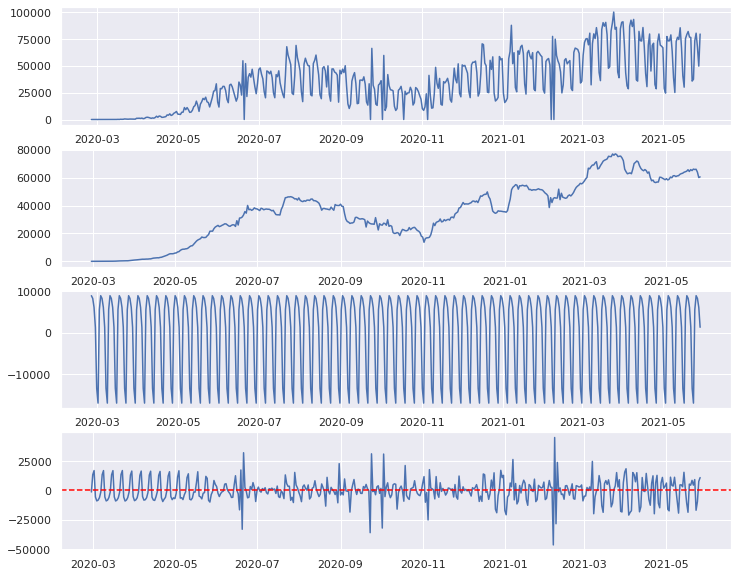

In [203]:
# Plotando o gráfico com os resultados
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (12,10))

ax1.plot(res.observed)
ax2.plot(res.trend)
ax3.plot(res.seasonal)
ax4.plot(confirmados.index, res.resid)
ax4.axhline(0, linestyle='dashed', c='red')
plt.show()

### 9.2.1) Modelando dados com ARIMA

In [211]:
modelo = auto_arima(novos_casos)
fig = go.Figure(go.Scatter(x=novos_casos.index, y=novos_casos, name='Observados'))

fig.add_trace(go.Scatter(x=novos_casos.index, y=modelo.predict_in_sample(), name='Preditos'))

fig.add_trace(go.Scatter(x=pd.date_range('2021-05-28', '2021-06-28'), y=modelo.predict(30), name='Previsão'))

fig.show()

### 9.2.2) Modelando dados com fbprophet

In [312]:
# Separando dataset em Treino e Teste
train = novos_casos.reset_index()[:-80]
test = novos_casos.reset_index()[-80:]

# Renomeando colunas
train.rename(columns={'observationdate':'ds', 'new_cases':'y'}, inplace=True)
test.rename(columns={'observationdate':'ds', 'new_cases':'y'}, inplace=True)

# Definir o modelo de crescimento 
my_model = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative')

# Treinando o modelo
my_model.fit(train)

# Construindo previsões
future_dates = my_model.make_future_dataframe(periods = 120, freq='D')
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
0,2020-02-26,-3547.951893,-15079.566972,8663.883066
1,2020-02-27,-3440.274609,-14740.528464,8105.687986
2,2020-02-28,-2940.077230,-13206.178228,8302.233271
3,2020-02-29,-2545.415435,-13832.959099,8443.583372
4,2020-03-01,-1590.533417,-13103.824730,9570.329289


In [313]:
fig = go.Figure(go.Scatter(x=forecast.ds, y=forecast.yhat, name='Predição'))
fig.add_trace(go.Scatter(x=test.ds, y=test.y, name='Observados - Teste'))
fig.add_trace(go.Scatter(x=train.ds, y=train.y, name='Observações - Treino'))
fig.show()

#### 9.2.2.1) Cross-Validation 

In [314]:
# Visualmente já vemos que o modelo precisa passar por alguns ajustes, mas vamos ver, com dados, quão assertivo é nosso modelo:
my_model_cv = cross_validation(my_model, initial='200 days', period='80 days', horizon = '80 days')
my_model_p = performance_metrics(my_model_cv)

INFO:prophet:Making 2 forecasts with cutoffs between 2020-10-01 00:00:00 and 2020-12-20 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


In [315]:
# Percebemos que o mdape é aproximadamente 34% e tem a cobertura de 47%, o que é bem baixo;
my_model_p.mean()

horizon     44 days 00:00:00
mse         384687504.872672
rmse            18361.585164
mae             14440.507009
mdape               0.349495
coverage            0.472603
dtype: object

/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:526: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.

/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:527: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



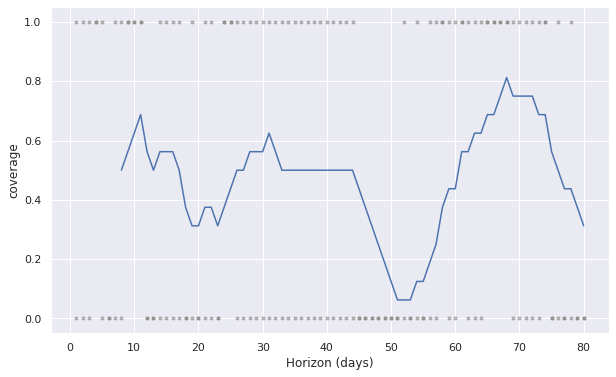

In [316]:
# Em determinadas situações vemos uma cobertura de até 80%. Modelo precisa de mais ajustes
fig = plot_cross_validation_metric(my_model_cv, metric='coverage')